In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    make_scorer,
    mean_squared_error,
    r2_score,
    explained_variance_score,
    mean_absolute_error,
    f1_score,
    jaccard_score,
)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read fingerprint file and experimental file

In [3]:
receptors = pd.read_csv(
    "/Users/xiaomuou620/Desktop/PRIVATE_DATA/hallucinome.csv"
) 
fingerprints = pd.read_csv('../../data/ExperimentData/MACCS_fingerprints.csv')
print(receptors.head())
print(fingerprints.head())
print(fingerprints.shape)



  receptor gprotein        drug    Emax  Emax_SE    TCoeff  TCoeff_SE  \
0    5HT1A      Gi1   25C-NBOMe  999.00   999.00       NaN        NaN   
1    5HT1A      Gi1    25I-NBMD   18.62     2.06  8.878197   0.201061   
2    5HT1A      Gi1   25I-NBOMe   24.53     3.28  7.947086   0.195392   
3    5HT1A      Gi1  25T7-NBOMe   22.00     3.87  7.457872   0.217788   
4    5HT1A      Gi1  4-AcO-MALT   38.93     5.16  7.417719   0.148907   

    logEmEC  logEmEc_Lower  logEmEc_Upper   pEC50  pEC50_SE  N  
0       NaN            NaN            NaN  999.00    999.00  3  
1  8.879980       8.529060       9.225551    7.61      0.30  3  
2  7.949698       7.607359       8.284201    6.56      0.28  3  
3  7.462423       7.078398       7.832796    6.12      0.30  3  
4  7.420284       7.158531       7.674340    5.83      0.20  3  
         Name  0  1  2  3  4  5  6  7  8  ...  157  158  159  160  161  162  \
0        5-HT  0  0  0  0  0  0  0  0  0  ...    1    1    1    0    1    1   
1  4-AcO-MALT

### Experimental data processing

For all the data, only use the highest Emax as input for each molecule-receptor binding info.

Every molecule-receptor binding involves g proteins, we only take largest Emax value among the involving g proteins.

In [4]:
# replace 999 in Emax with 0
receptors["Emax"] = receptors["Emax"].replace(999, 0)
# print(receptors.head())

# collect receptors for each drug
receptor_emax_mapping = (
    receptors.groupby(["drug", "receptor"])["Emax"].max().reset_index()
)
# print(receptor_emax_mapping.head())

# pivot the table to have drugs as rows and receptors as columns
receptor_emax_mapping_pivot = receptor_emax_mapping.pivot(
    index="drug", columns="receptor", values="Emax"
).reset_index()
print(receptor_emax_mapping_pivot.head())

receptor_emax_mapping_pivot.fillna(0, inplace=True)
print(receptor_emax_mapping_pivot.shape)

receptor        drug      5HT1A       5HT1B   5HT1D   5HT1E       5HT1F  \
0          25C-NBOMe  13.047601    0.000000   61.56    0.00    0.000000   
1           25I-NBMD  27.200000   84.239297   91.94  105.26  102.099230   
2          25I-NBOMe  45.370000    0.000000   53.65   33.92   64.596780   
3         25T7-NBOMe  31.991315    0.000000   31.81    0.00   69.116817   
4         4-AcO-MALT  50.677696  126.170618  101.04  115.53  102.552716   

receptor   5HT2A  5HT2B   5HT2C  5HT5A  ...  Alpha2B  Alpha2C  Beta1AR  \
0         126.52  67.19   98.15   0.00  ...      0.0      0.0      0.0   
1         102.02  45.49   79.79   0.00  ...      0.0      0.0      0.0   
2         108.36  72.04  104.43  27.97  ...      0.0      0.0      0.0   
3          99.15  53.73   94.85  36.81  ...      0.0      0.0      0.0   
4         102.61  68.11  110.35  43.88  ...      0.0      0.0      0.0   

receptor  Beta2AR  Beta3AR  DRD1   DRD2   DRD3  DRD4   DRD5  
0             0.0      0.0   0.0  50.60   

### Fingerprint data processing

In [5]:
# Extract the names (first column)
drug_names_fingerprints = fingerprints['Name']
fingerprints_detail = fingerprints.drop('Name', axis=1)  # Drop the name column by index

# Create a dictionary where names are keys and fingerprints are lists of values
# csv_dict = {name: fingerprint.tolist() for name, fingerprint in zip(drug_names_fingerprints, fingerprints_detail.values)}


### Merge feature and values

To ensure the order of features and values match based on molecules.

Here, labels have 44 lines and fingerprints have 43 lines, including the header.

Since I cannot find the category and SMILES of METALLED, when merging the data, METALLED data will be disgarded.

In [6]:
# merge receptor_emax_mapping_pivot with fingerprints
# data_merged = pd.merge(
#     receptor_emax_mapping_pivot, fingerprints, left_on="drug", right_on="Name"
# ).drop(columns=["Name"])

data_merged = pd.merge(
    fingerprints.assign(Name_lower=fingerprints["Name"].str.strip().str.lower()),
    receptor_emax_mapping_pivot.assign(
        drug_lower=receptor_emax_mapping_pivot["drug"].str.strip().str.lower()
    ),
    left_on="Name_lower",
    right_on="drug_lower",
    how="left",
)

data_merged.drop(columns=["Name_lower", "drug_lower"], inplace=True)

# data_merged.to_csv(
#     "/Users/xiaomuou620/Desktop/PRIVATE_DATA/selected_file_realval.csv", index=False
# )
print(data_merged.head())
print(data_merged.shape)

         Name  0  1  2  3  4  5  6  7  8  ...  Alpha2B  Alpha2C  Beta1AR  \
0        5-HT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   
1  4-AcO-MALT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   
2   5-MeO-DMT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   
3  5-MeO-DALT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   
4  5-MeO-DiPT  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0   

   Beta2AR  Beta3AR  DRD1    DRD2    DRD3   DRD4   DRD5  
0      0.0      0.0   0.0  102.81  100.11   0.00   0.00  
1      0.0      0.0   0.0   61.99   85.60   0.00   0.00  
2      0.0      0.0   0.0   58.32   98.14  82.27   0.00  
3      0.0      0.0   0.0   85.37   77.33  96.92  20.34  
4      0.0      0.0   0.0    0.00    0.00  23.29   0.00  

[5 rows x 194 columns]
(43, 194)


# Training

In [7]:
# Drop the 'receptor' column
data_merged = data_merged.drop(columns=["Name", "drug"])
print(data_merged.head())

   0  1  2  3  4  5  6  7  8  9  ...  Alpha2B  Alpha2C  Beta1AR  Beta2AR  \
0  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   
1  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   
2  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   
3  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   
4  0  0  0  0  0  0  0  0  0  0  ...      0.0      0.0      0.0      0.0   

   Beta3AR  DRD1    DRD2    DRD3   DRD4   DRD5  
0      0.0   0.0  102.81  100.11   0.00   0.00  
1      0.0   0.0   61.99   85.60   0.00   0.00  
2      0.0   0.0   58.32   98.14  82.27   0.00  
3      0.0   0.0   85.37   77.33  96.92  20.34  
4      0.0   0.0    0.00    0.00  23.29   0.00  

[5 rows x 192 columns]


Since MACCS only has 166 bits and the first bit 0 always unset and may be ignored. Only bits 1-166 will be set

In [8]:
X = data_merged.iloc[:, 1:167]
y = data_merged.iloc[:, 167:]

print(X.shape, y.shape)
print(X.head())
print(y.head())


(43, 166) (43, 25)
   1  2  3  4  5  6  7  8  9  10  ...  157  158  159  160  161  162  163  164  \
0  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    0    1    1    1    1   
1  0  0  0  0  0  0  0  0  0   0  ...    1    1    1    1    1    1    1    1   
2  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
3  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   
4  0  0  0  0  0  0  0  0  0   0  ...    1    1    0    1    1    1    1    1   

   165  166  
0    1    0  
1    1    0  
2    1    0  
3    1    0  
4    1    0  

[5 rows x 166 columns]
        5HT1A       5HT1B   5HT1D   5HT1E       5HT1F   5HT2A   5HT2B   5HT2C  \
0  100.092869  103.121191  100.18  100.00  100.492669  100.03  100.00  101.54   
1   50.677696  126.170618  101.04  115.53  102.552716  102.61   68.11  110.35   
2   99.975644  133.393687  111.07  105.54   97.499582  101.18   78.36  122.64   
3   96.610000  120.412851  102.32  101.26   85.529384   94.33 

## Multioutput Regression Task + Nested CV

In [9]:
# Outer cross-validation (model evaluation)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []

# Inner cross-validation (hyperparameter tuning)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
label_metrics = {label: [] for label in y.columns}


def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_categorical("max_depth", [None, 10, 20])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    threshold = trial.suggest_float(
        "threshold", 0, 20
    )  # Threshold for binary classification

    # Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
    )

    inner_scores = []
    # Evaluate using inner CV
    for train_idx, val_idx in inner_cv.split(X_train):
        X_train_inner, X_val_inner = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_inner, y_val_inner = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        rf.fit(X_train_inner, y_train_inner)

        # Predict real values
        y_pred_inner = rf.predict(X_val_inner)

        # Apply threshold to convert real values to binary classification
        y_pred_inner_bool = (y_pred_inner >= threshold).astype(int)
        y_val_inner_bool = (y_val_inner >= threshold).astype(int)

        # Calculate Hamming Loss
        hamming_loss_inner = hamming_loss(y_val_inner_bool, y_pred_inner_bool)

        # Append score
        inner_scores.append(hamming_loss_inner)

    return np.mean(inner_scores)


# Outer loop
for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Optuna hyperparameter tuning
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)

    # Train the best model on the full training set
    best_params = study.best_params
    best_rf = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        random_state=42,
    )
    best_rf.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)

    # Apply optimized threshold for classification
    threshold = study.best_trial.params["threshold"]
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)

    # Classification metrics
    hamming = hamming_loss(y_test_binary, y_pred_binary)
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    f1 = f1_score(y_test_binary, y_pred_binary, average="weighted")

    # Store all scores
    outer_scores.append(
        {
            "hamming_loss": hamming_loss(y_test_binary, y_pred_binary),
            "accuracy": accuracy_score(y_test_binary, y_pred_binary),
            "f1_score": f1_score(y_test_binary, y_pred_binary, average="weighted"),
            "jaccard_samples": jaccard_score(
                y_test_binary, y_pred_binary, average="samples"
            ),
        }
    )
    
    # Calculate metrics for each label
    for label in y.columns:
        label_metrics[label].append(
            {
                "accuracy": accuracy_score(
                    y_test_binary[label], y_pred_binary[:, y.columns.get_loc(label)]
                ),
                "hamming_loss": hamming_loss(
                    y_test_binary[label], y_pred_binary[:, y.columns.get_loc(label)]
                ),
                "f1_score": f1_score(
                    y_test_binary[label], y_pred_binary[:, y.columns.get_loc(label)]
                ),
                "jaccard_score": jaccard_score(
                    y_test_binary[label], y_pred_binary[:, y.columns.get_loc(label)]
                ),
            }
        )

# Print final scores
for i, scores in enumerate(outer_scores):
    print(f"Fold {i+1}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")


[I 2025-01-10 15:11:07,752] A new study created in memory with name: no-name-decad56c-15af-4913-bedb-ca6bb9182889
[I 2025-01-10 15:11:08,250] Trial 0 finished with value: 0.33180952380952383 and parameters: {'n_estimators': 82, 'max_depth': 10, 'min_samples_split': 8, 'threshold': 7.100799579620718}. Best is trial 0 with value: 0.33180952380952383.
[I 2025-01-10 15:11:08,685] Trial 1 finished with value: 0.4167619047619048 and parameters: {'n_estimators': 152, 'max_depth': None, 'min_samples_split': 9, 'threshold': 2.6663032006299314}. Best is trial 0 with value: 0.33180952380952383.
[I 2025-01-10 15:11:09,129] Trial 2 finished with value: 0.21885714285714286 and parameters: {'n_estimators': 158, 'max_depth': None, 'min_samples_split': 9, 'threshold': 17.7863364795389}. Best is trial 2 with value: 0.21885714285714286.
[I 2025-01-10 15:11:09,729] Trial 3 finished with value: 0.1923809523809524 and parameters: {'n_estimators': 191, 'max_depth': None, 'min_samples_split': 3, 'threshold': 

Fold 1:
  hamming_loss: 0.1378
  accuracy: 0.1111
  f1_score: 0.9045
  jaccard_samples: 0.7804
Fold 2:
  hamming_loss: 0.1822
  accuracy: 0.1111
  f1_score: 0.8227
  jaccard_samples: 0.6924
Fold 3:
  hamming_loss: 0.2044
  accuracy: 0.0000
  f1_score: 0.8168
  jaccard_samples: 0.6912
Fold 4:
  hamming_loss: 0.1650
  accuracy: 0.1250
  f1_score: 0.8688
  jaccard_samples: 0.7669
Fold 5:
  hamming_loss: 0.1350
  accuracy: 0.0000
  f1_score: 0.9186
  jaccard_samples: 0.7849


/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/xiaomuou620/opt/miniconda3/envs/Project1/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _

# Evaluation and Visualization


Metrics for label: 5HT1A
Accuracy: Mean = 0.88, Std = 0.11
Hamming_loss: Mean = 0.12, Std = 0.11
F1_score: Mean = 0.93, Std = 0.06
Jaccard_score: Mean = 0.88, Std = 0.11

Metrics for label: 5HT1B
Accuracy: Mean = 0.86, Std = 0.11
Hamming_loss: Mean = 0.14, Std = 0.11
F1_score: Mean = 0.92, Std = 0.07
Jaccard_score: Mean = 0.86, Std = 0.11

Metrics for label: 5HT1D
Accuracy: Mean = 0.93, Std = 0.06
Hamming_loss: Mean = 0.07, Std = 0.06
F1_score: Mean = 0.96, Std = 0.03
Jaccard_score: Mean = 0.93, Std = 0.06

Metrics for label: 5HT1E
Accuracy: Mean = 0.89, Std = 0.14
Hamming_loss: Mean = 0.11, Std = 0.14
F1_score: Mean = 0.94, Std = 0.08
Jaccard_score: Mean = 0.89, Std = 0.14

Metrics for label: 5HT1F
Accuracy: Mean = 0.91, Std = 0.08
Hamming_loss: Mean = 0.09, Std = 0.08
F1_score: Mean = 0.95, Std = 0.05
Jaccard_score: Mean = 0.91, Std = 0.08

Metrics for label: 5HT2A
Accuracy: Mean = 0.91, Std = 0.05
Hamming_loss: Mean = 0.09, Std = 0.05
F1_score: Mean = 0.95, Std = 0.02
Jaccard_score

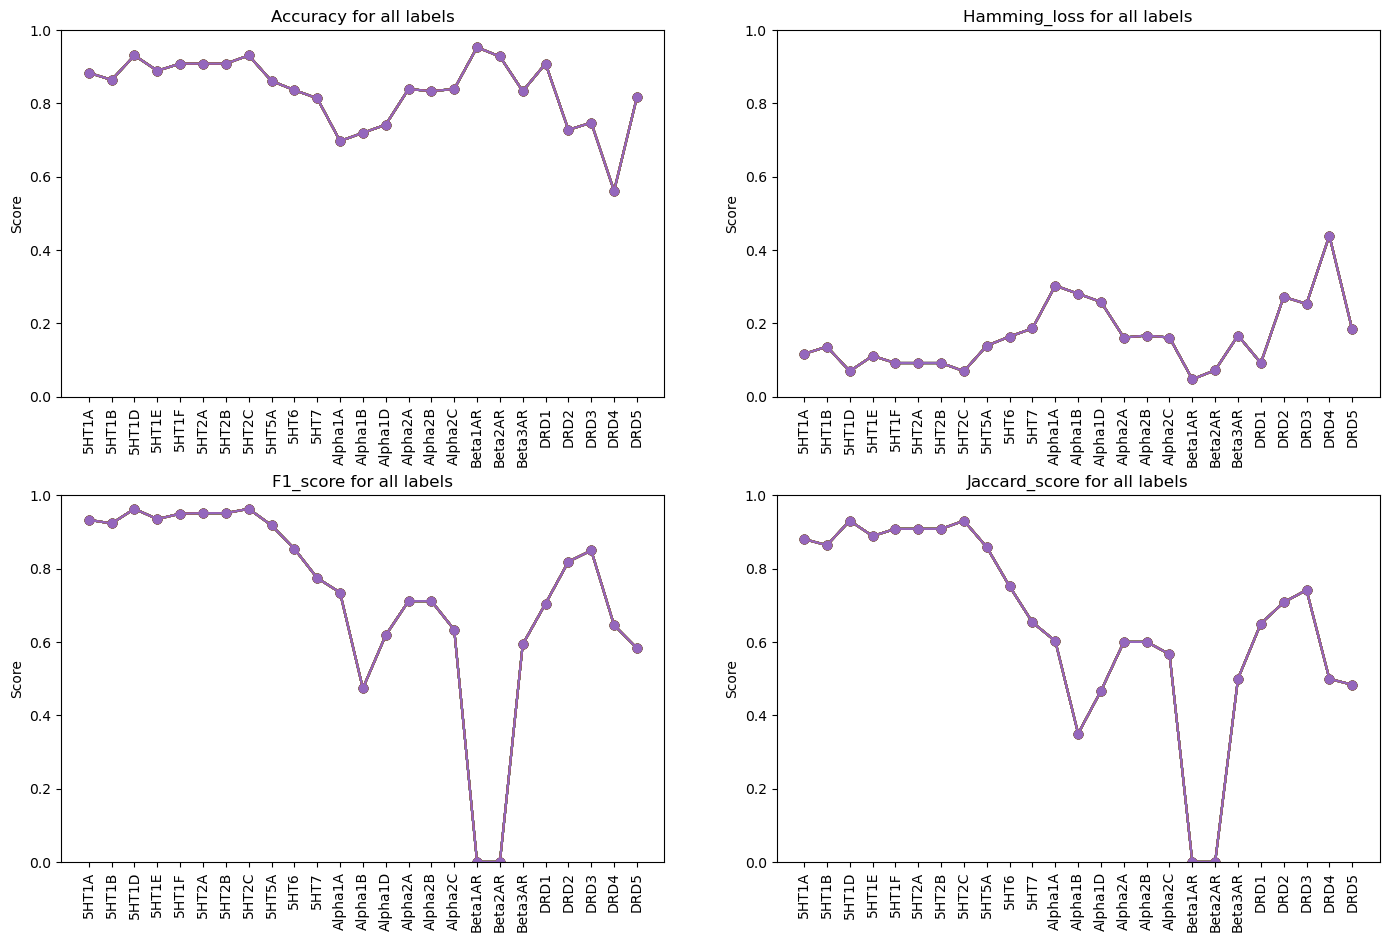

In [10]:
cv_label_metrics_summary = {}
for label, scores in label_metrics.items():
    cv_label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    cv_label_metrics_summary[label] = {
        metric: (np.mean(values), np.std(values))
        for metric, values in cv_label_metrics.items()
    }


# Calculate mean and standard deviation for each label's metrics
for label, scores in label_metrics.items():
    print(f"\nMetrics for label: {label}")
    each_label_metrics = {key: [score[key] for score in scores] for key in scores[0]}
    for metric, values in each_label_metrics.items():
        print(
            f"{metric.capitalize()}: Mean = {np.mean(values):.2f}, Std = {np.std(values):.2f}"
        )


# Plotting the metrics for each label
metrics_to_plot = ["accuracy", "hamming_loss", "f1_score", "jaccard_score"]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.tight_layout(pad=5.0)


for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    ax.set_title(f"{metric.capitalize()} for all labels")
    for label in y.columns:
        means = [cv_label_metrics_summary[label][metric][0] for label in y.columns]
        stds = [cv_label_metrics_summary[label][metric][1] for label in y.columns]
        ax.plot(y.columns, means, marker="o", label=label)
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    # ax.legend()
    ax.set_xticks(range(len(y.columns)))
    ax.set_xticklabels(y.columns, rotation=90)

plt.show()


In [11]:
print(best_params)

{'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 5, 'threshold': 19.955558232902714}
